<h1>ENSEMBLE METHODS</h1>

<h3>Vado a fare Random Forest, AdaBoost e Grandient Boost (eventualmente anche nella versione Light GBM) </h3>

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, classification_report, roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay
from scikitplot.metrics import plot_roc
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import copy


In [2]:
#importo il train e test encoded (sto importando quelli GIÀ ONE HOT ENCODED)
df_train = pd.read_csv('df_train_mod2.csv')
df_test = pd.read_csv('df_test_mod2.csv')

In [3]:
#Prendo la variabile target, in questo caso emotion:
y_train = df_train['emotion']
y_test = df_test['emotion']

In [4]:
#tolgo emotion visto che l'ho salvata nella y - IMPORTANTE!
df_train.drop(columns=['emotion'],inplace=True)
df_test.drop(columns=['emotion'],inplace=True)

In [5]:
columns_to_scale_train = df_train.iloc[:, :-5]
columns_to_scale_test = df_test.iloc[:, :-5]


# Extract the columns to be kept as they are
columns_to_keep_train = df_train.iloc[:, -5:]
columns_to_keep_test = df_test.iloc[:, -5:]

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit and transform the columns to be scaled
scaler.fit(columns_to_scale_train) #faccio il fit solo sulle colonne del train!
train_scaled = scaler.transform(columns_to_scale_train)
test_scaled = scaler.transform(columns_to_scale_test)


# Concatenate the scaled columns and the columns to be kept
df_train = pd.concat([pd.DataFrame(train_scaled, columns=columns_to_scale_train.columns), columns_to_keep_train], axis=1)
df_test = pd.concat([pd.DataFrame(test_scaled, columns=columns_to_scale_test.columns), columns_to_keep_test], axis=1)

In [6]:
# Salvo in x_train e x_test i valori 
x_train = df_train.values
x_test = df_test.values

<h3>Random Forest</h3>

In [8]:
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

Cosa vado a fare: <br>
- Hyper-parameter tuning su tutto l'x_test con la random search e vado ad allenare il modello con i parametri migliori, stampando il classification report;
- Vado a vedere la feature importance per questo modello e faccio un dataset con solo le k feature che vengono considerate più importanti;
- Con il dataset con le k feature più importanti vado a fare di nuovo hyper parameter tuning, e a vedere l'accuracy;
- Su uno dei due vado a fare il plot dell'accuracy al variare del numero di stimatori che vengono usati - sarebbe molto bello fare il plot con entrambi sovrapposti, facendo vedere l'accuracy allenando su tutto e l'accuracy allenando invece soltanto su quelle migliori

In [9]:
rfc = RandomForestClassifier()


In [11]:
param_list = {'min_samples_split': [2, 5, 10, 20],
              'min_samples_leaf': [1, 5, 10, 20],
              'max_depth': [None] + list(np.arange(2, 20)),
              'criterion':['gini','entropy','log_loss'],
             }

random_search = RandomizedSearchCV(rfc, param_distributions=param_list, n_iter=20, cv=5, random_state=42)
random_search.fit(x_train, y_train)
random_search.best_params_

#best params: 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 15, 'criterion': 'entropy'


/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1863, in __call__
    return output 

{'min_samples_split': 10,
 'min_samples_leaf': 5,
 'max_depth': 15,
 'criterion': 'entropy'}

In [12]:
#alleno il modello con i migliori parametri
rfc1 = RandomForestClassifier(criterion='entropy',min_samples_leaf=5, min_samples_split=10, max_depth=15)
rfc1.fit(x_train, y_train)

y_pred_rfc1 = rfc1.predict(x_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred_rfc1))
print('F1-score %s' % f1_score(y_test, y_pred_rfc1, average=None))
print(classification_report(y_test, y_pred_rfc1))


Accuracy 0.4375
F1-score [0.61603376 0.58215962 0.5        0.34532374 0.33816425 0.18461538
 0.27118644 0.43859649]
              precision    recall  f1-score   support

           0       0.52      0.76      0.62        96
           1       0.53      0.65      0.58        96
           2       0.50      0.50      0.50        48
           3       0.56      0.25      0.35        96
           4       0.32      0.36      0.34        96
           5       0.35      0.12      0.18        48
           6       0.30      0.25      0.27        96
           7       0.38      0.52      0.44        48

    accuracy                           0.44       624
   macro avg       0.43      0.43      0.41       624
weighted avg       0.44      0.44      0.42       624



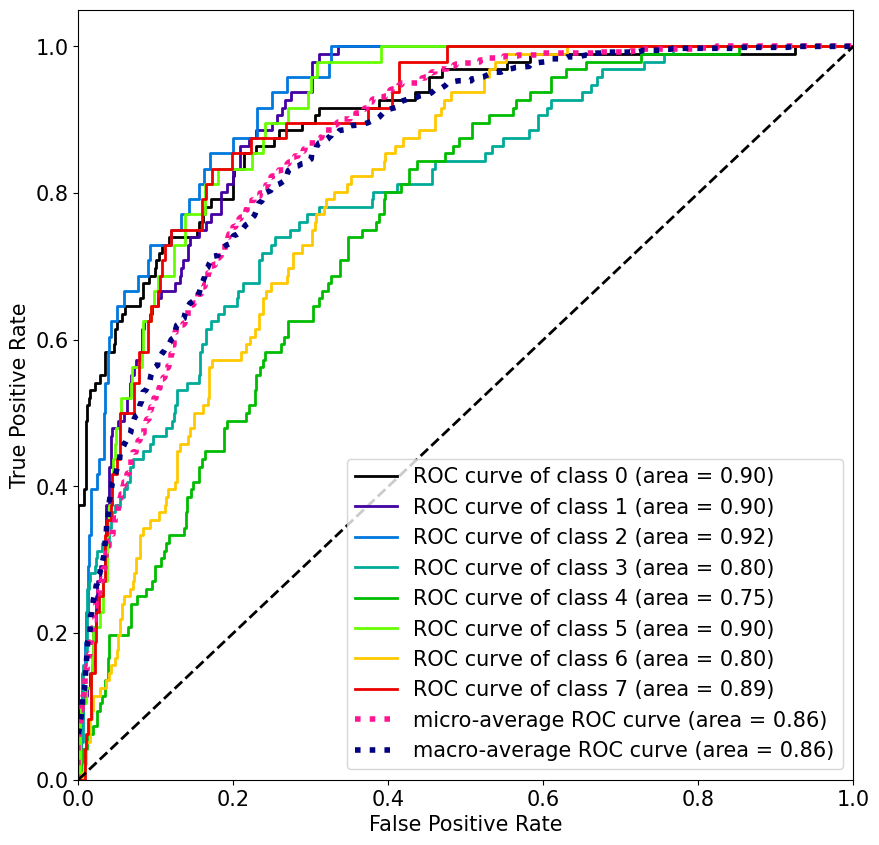

In [13]:
y_score_rfc1 = rfc1.predict_proba(x_test)
plot_roc(y_test, y_score_rfc1, figsize=(10,10), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.show()

array([[70,  0,  1,  0, 12,  1,  1, 11],
       [ 0, 70,  1,  0, 11,  0, 14,  0],
       [15,  2, 18,  0,  4,  0,  4,  5],
       [24,  5,  4, 24, 19,  4,  9,  7],
       [27,  5,  0,  9, 36,  1,  6, 12],
       [ 2,  8,  0,  0, 10, 12, 13,  3],
       [ 5, 37,  9,  1, 10,  5, 28,  1],
       [ 6,  2,  1,  6,  5,  0,  3, 25]])

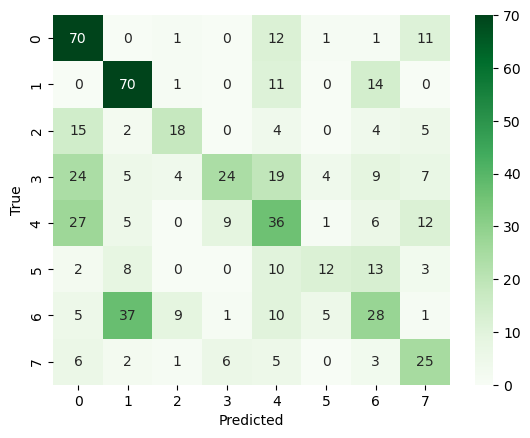

In [71]:
cm_rfc1 = confusion_matrix(y_test, y_pred_rfc1)
sns.heatmap(cm_rfc1, annot=True, cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('True')
cm_rfc1

In [16]:
#Getting feature importance: 
import json
json.dumps(classification_report(y_test, y_pred_rfc1, output_dict=True))

'{"0": {"precision": 0.5177304964539007, "recall": 0.7604166666666666, "f1-score": 0.6160337552742615, "support": 96}, "1": {"precision": 0.5299145299145299, "recall": 0.6458333333333334, "f1-score": 0.5821596244131456, "support": 96}, "2": {"precision": 0.5, "recall": 0.5, "f1-score": 0.5, "support": 48}, "3": {"precision": 0.5581395348837209, "recall": 0.25, "f1-score": 0.34532374100719426, "support": 96}, "4": {"precision": 0.3153153153153153, "recall": 0.3645833333333333, "f1-score": 0.3381642512077294, "support": 96}, "5": {"precision": 0.35294117647058826, "recall": 0.125, "f1-score": 0.18461538461538463, "support": 48}, "6": {"precision": 0.2962962962962963, "recall": 0.25, "f1-score": 0.2711864406779661, "support": 96}, "7": {"precision": 0.3787878787878788, "recall": 0.5208333333333334, "f1-score": 0.43859649122807015, "support": 48}, "accuracy": 0.4375, "macro avg": {"precision": 0.4311406535152788, "recall": 0.42708333333333337, "f1-score": 0.409509961052969, "support": 624}

In [18]:
json.loads(json.dumps(classification_report(y_test, y_pred_rfc1, output_dict=True)))

{'0': {'precision': 0.5177304964539007,
  'recall': 0.7604166666666666,
  'f1-score': 0.6160337552742615,
  'support': 96},
 '1': {'precision': 0.5299145299145299,
  'recall': 0.6458333333333334,
  'f1-score': 0.5821596244131456,
  'support': 96},
 '2': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.5, 'support': 48},
 '3': {'precision': 0.5581395348837209,
  'recall': 0.25,
  'f1-score': 0.34532374100719426,
  'support': 96},
 '4': {'precision': 0.3153153153153153,
  'recall': 0.3645833333333333,
  'f1-score': 0.3381642512077294,
  'support': 96},
 '5': {'precision': 0.35294117647058826,
  'recall': 0.125,
  'f1-score': 0.18461538461538463,
  'support': 48},
 '6': {'precision': 0.2962962962962963,
  'recall': 0.25,
  'f1-score': 0.2711864406779661,
  'support': 96},
 '7': {'precision': 0.3787878787878788,
  'recall': 0.5208333333333334,
  'f1-score': 0.43859649122807015,
  'support': 48},
 'accuracy': 0.4375,
 'macro avg': {'precision': 0.4311406535152788,
  'recall': 0.4270833333333

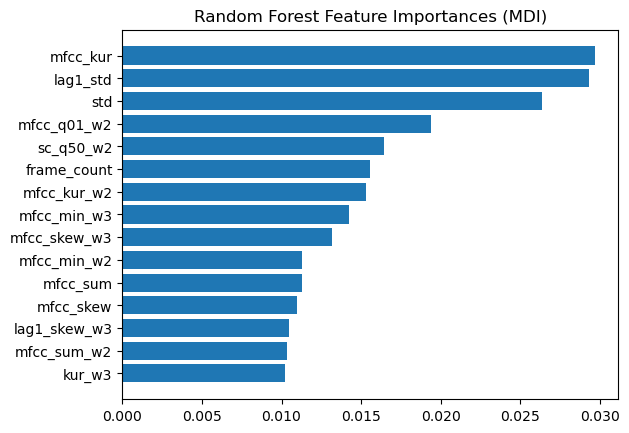

['kur_w3' 'mfcc_sum_w2' 'lag1_skew_w3' 'mfcc_skew' 'mfcc_sum'
 'mfcc_min_w2' 'mfcc_skew_w3' 'mfcc_min_w3' 'mfcc_kur_w2' 'frame_count'
 'sc_q50_w2' 'mfcc_q01_w2' 'std' 'lag1_std' 'mfcc_kur']


In [22]:
nbr_features = 15

tree_feature_importances = rfc1.feature_importances_
sorted_idx = tree_feature_importances.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, tree_feature_importances[sorted_idx])
plt.yticks(y_ticks, np.array(df_train.columns)[sorted_idx])
plt.title("Random Forest Feature Importances (MDI)")
plt.show()
print(np.array(df_train.columns)[sorted_idx])

In [23]:
colonne_importanti=list(np.array(df_train.columns)[sorted_idx])

In [26]:
df_train_ridotto = copy.deepcopy(df_train[colonne_importanti])
df_test_ridotto = copy.deepcopy(df_test[colonne_importanti])

In [29]:
x_train_ridotto = df_train_ridotto.values
x_test_ridotto = df_test_ridotto.values

In [30]:
param_list = {'min_samples_split': [2, 5, 10, 20],
              'min_samples_leaf': [1, 5, 10, 20],
              'max_depth': [None] + list(np.arange(2, 20)),
              'criterion':['gini','entropy','log_loss'],
             }

random_search = RandomizedSearchCV(rfc, param_distributions=param_list, n_iter=20, cv=5, random_state=42)
random_search.fit(x_train_ridotto, y_train)
random_search.best_params_

# Parametri migliori: {'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 15, 'criterion': 'entropy'} 
# I parametri migliori sono gli stessi del caso "intero"

/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
35 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/sklearn/ensemble/_forest.py", line 450, in fit
    trees = Parallel(
  File "/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1863, in __call__
    return output 

{'min_samples_split': 10,
 'min_samples_leaf': 5,
 'max_depth': 15,
 'criterion': 'entropy'}

In [32]:
#alleno il modello con i migliori parametri
rfc2 = RandomForestClassifier(criterion='entropy',min_samples_leaf=5, min_samples_split=10, max_depth=15)
rfc2.fit(x_train_ridotto, y_train)

y_pred_rfc2 = rfc2.predict(x_test_ridotto)

print('Accuracy %s' % accuracy_score(y_test, y_pred_rfc2))
print('F1-score %s' % f1_score(y_test, y_pred_rfc2, average=None))
print(classification_report(y_test, y_pred_rfc2))

# Con solamente 15 feature si  ottiene una accuracy di 0.415, invece di 0.4375 come il caso "intero" 

Accuracy 0.4150641025641026
F1-score [0.56302521 0.52173913 0.47826087 0.12903226 0.35820896 0.31578947
 0.2754491  0.51666667]
              precision    recall  f1-score   support

           0       0.47      0.70      0.56        96
           1       0.45      0.62      0.52        96
           2       0.50      0.46      0.48        48
           3       0.29      0.08      0.13        96
           4       0.34      0.38      0.36        96
           5       0.43      0.25      0.32        48
           6       0.32      0.24      0.28        96
           7       0.43      0.65      0.52        48

    accuracy                           0.42       624
   macro avg       0.40      0.42      0.39       624
weighted avg       0.39      0.42      0.39       624



In [35]:
# Vado a plottare l'accuracy dei due modelli al variare del numero di stimatori, che fino ad adesso è stato mantenuto di default = 100 
# Mentre gli altri parametri li lasciamo come trovati nelle search

max_k=200
acc_intero = []
acc_ridotto = []

for k in range(20, max_k+1):
    rfc1 = RandomForestClassifier(n_estimators = k, criterion='entropy',min_samples_leaf=5, min_samples_split=10, max_depth=15)
    rfc2 = RandomForestClassifier(n_estimators = k, criterion='entropy',min_samples_leaf=5, min_samples_split=10, max_depth=15)
    rfc1.fit(x_train, y_train)
    rfc2.fit(x_train_ridotto,y_train)
    
    y_pred_rfc1 = rfc1.predict(x_test)
    y_pred_rfc2 = rfc2.predict(x_test_ridotto)

    acc_intero.append(accuracy_score(y_test, y_pred_rfc1))
    acc_ridotto.append(accuracy_score(y_test, y_pred_rfc2))

    print(f'{k}th fit done')
    


20th fit done
21th fit done
22th fit done
23th fit done
24th fit done
25th fit done
26th fit done
27th fit done
28th fit done
29th fit done
30th fit done
31th fit done
32th fit done
33th fit done
34th fit done
35th fit done
36th fit done
37th fit done
38th fit done
39th fit done
40th fit done
41th fit done
42th fit done
43th fit done
44th fit done
45th fit done
46th fit done
47th fit done
48th fit done
49th fit done
50th fit done
51th fit done
52th fit done
53th fit done
54th fit done
55th fit done
56th fit done
57th fit done
58th fit done
59th fit done
60th fit done
61th fit done
62th fit done
63th fit done
64th fit done
65th fit done
66th fit done
67th fit done
68th fit done
69th fit done
70th fit done
71th fit done
72th fit done
73th fit done
74th fit done
75th fit done
76th fit done
77th fit done
78th fit done
79th fit done
80th fit done
81th fit done
82th fit done
83th fit done
84th fit done
85th fit done
86th fit done
87th fit done
88th fit done
89th fit done
90th fit done
91th f

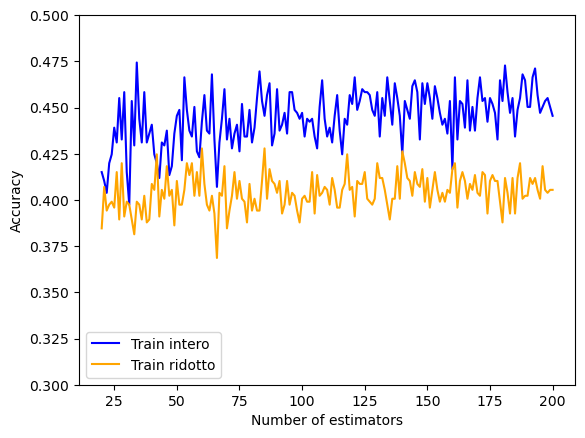

In [40]:
k_values = list(range(20, 201))

# Plotting
plt.plot(k_values, acc_intero, label='Train intero', color='blue')
plt.plot(k_values, acc_ridotto, label='Train ridotto', color='orange')

# Adding labels and title
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')

# Adding a legend
plt.legend()

plt.ylim(0.3, 0.5)  # Replace 0 and 1 with your desired y-axis range


# Display the plot
plt.show()

In [41]:
max_k=200
acc_intero = []
acc_ridotto = []

for k in range(20, max_k+1,5):
    rfc1 = RandomForestClassifier(n_estimators = k, criterion='entropy',min_samples_leaf=5, min_samples_split=10, max_depth=15)
    rfc2 = RandomForestClassifier(n_estimators = k, criterion='entropy',min_samples_leaf=5, min_samples_split=10, max_depth=15)
    rfc1.fit(x_train, y_train)
    rfc2.fit(x_train_ridotto,y_train)
    
    y_pred_rfc1 = rfc1.predict(x_test)
    y_pred_rfc2 = rfc2.predict(x_test_ridotto)

    acc_intero.append(accuracy_score(y_test, y_pred_rfc1))
    acc_ridotto.append(accuracy_score(y_test, y_pred_rfc2))

    print(f'{k}th fit done')
    

20th fit done
25th fit done
30th fit done
35th fit done
40th fit done
45th fit done
50th fit done
55th fit done
60th fit done
65th fit done
70th fit done
75th fit done
80th fit done
85th fit done
90th fit done
95th fit done
100th fit done
105th fit done
110th fit done
115th fit done
120th fit done
125th fit done
130th fit done
135th fit done
140th fit done
145th fit done
150th fit done
155th fit done
160th fit done
165th fit done
170th fit done
175th fit done
180th fit done
185th fit done
190th fit done
195th fit done
200th fit done


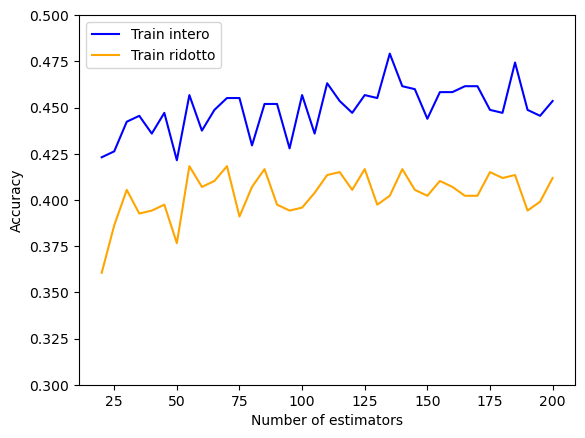

In [43]:
k_values = list(range(20, 201,5))

# Plotting
plt.plot(k_values, acc_intero, label='Train intero', color='blue')
plt.plot(k_values, acc_ridotto, label='Train ridotto', color='orange')

# Adding labels and title
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')

# Adding a legend
plt.legend()

plt.ylim(0.3, 0.5)  # Replace 0 and 1 with your desired y-axis range


# Display the plot
plt.show()

<h3>ADABOOST</h3>

In [44]:
from sklearn.ensemble import AdaBoostClassifier

Cosa vado a fare: <br>
- Confrontare quello che fa il modello base (che usa i decision stump come base classifiers) e fare hyperparameter tuning su questi
- con quello che fa il modello se metto come base classifier RandomForest -> si riesce ad ottenere un modello più robusto, che migliora le prestazioni?
- Andare ad analizzare in qualche modo la feature importance dei due modelli - printarla e vedere se c'è qualcosa di interessante

In [45]:
abc1 = AdaBoostClassifier(base_estimator=None)

In [46]:
param_list = {'n_estimators': [50,75,100,125],
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
             }

random_search = RandomizedSearchCV(abc1, param_distributions=param_list, n_iter=20, cv=5, random_state=42)
random_search.fit(x_train, y_train)
random_search.best_params_

{'n_estimators': 75, 'learning_rate': 0.2}

In [47]:
abc1 = AdaBoostClassifier(base_estimator=None, n_estimators=75, learning_rate=0.2, random_state=42)
abc1.fit(x_train, y_train)

y_pred_abc1 = abc1.predict(x_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred_abc1))
print('F1-score %s' % f1_score(y_test, y_pred_abc1, average=None))
print(classification_report(y_test, y_pred_abc1))

#l'accuracy viene di 0.359 quindi decisamente più bassa del random Forest

Accuracy 0.358974358974359
F1-score [0.48249027 0.42424242 0.38888889 0.24817518 0.3083004  0.3030303
 0.30167598 0.31325301]
              precision    recall  f1-score   support

           0       0.39      0.65      0.48        96
           1       0.51      0.36      0.42        96
           2       0.35      0.44      0.39        48
           3       0.41      0.18      0.25        96
           4       0.25      0.41      0.31        96
           5       0.56      0.21      0.30        48
           6       0.33      0.28      0.30        96
           7       0.37      0.27      0.31        48

    accuracy                           0.36       624
   macro avg       0.39      0.35      0.35       624
weighted avg       0.39      0.36      0.35       624



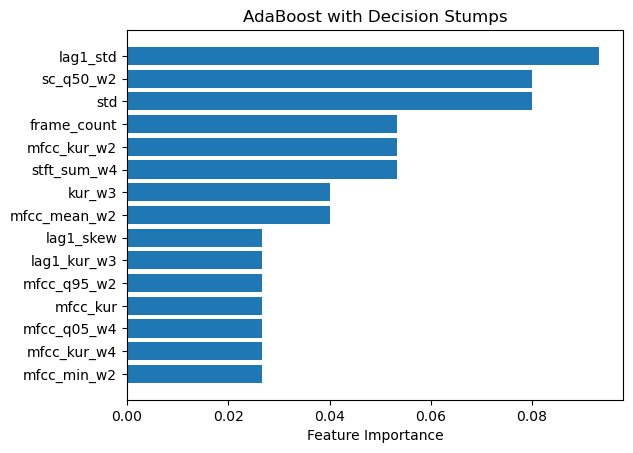

['mfcc_min_w2' 'mfcc_kur_w4' 'mfcc_q05_w4' 'mfcc_kur' 'mfcc_q95_w2'
 'lag1_kur_w3' 'lag1_skew' 'mfcc_mean_w2' 'kur_w3' 'stft_sum_w4'
 'mfcc_kur_w2' 'frame_count' 'std' 'sc_q50_w2' 'lag1_std']


In [65]:
nbr_features = 15

feature_importances_abc1 = abc1.feature_importances_
sorted_idx = feature_importances_abc1.argsort()[-nbr_features:]

y_ticks = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks, feature_importances_abc1[sorted_idx])
plt.yticks(y_ticks, np.array(df_train.columns)[sorted_idx])
plt.title("AdaBoost with Decision Stumps")
plt.xlabel('Feature Importance')
plt.show()
print(np.array(df_train.columns)[sorted_idx])

In [55]:
# Create an instance of RandomForestClassifier
rf_classifier = RandomForestClassifier()

# Use it as the base estimator for AdaBoostClassifier
abc2 = AdaBoostClassifier(base_estimator=rf_classifier)

In [56]:
param_list = {'n_estimators': [50, 75, 100, 125],
              'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.5],
             }

random_search = RandomizedSearchCV(abc2, param_distributions=param_list, n_iter=20, cv=5, random_state=42)
random_search.fit(x_train, y_train)
print(random_search.best_params_)

{'n_estimators': 125, 'learning_rate': 0.01}


In [58]:
#Alleno con i parametri migliori
abc2 = AdaBoostClassifier(base_estimator=RandomForestClassifier(), n_estimators=125, learning_rate=0.01, random_state=42)
abc2.fit(x_train, y_train)

y_pred_abc2 = abc2.predict(x_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred_abc2))
print('F1-score %s' % f1_score(y_test, y_pred_abc2, average=None))
print(classification_report(y_test, y_pred_abc2))

#In questo modo l'accuracy sale decisamente, ed arriva a 0.46

Accuracy 0.4599358974358974
F1-score [0.62240664 0.58937198 0.35897436 0.38095238 0.40952381 0.34666667
 0.33879781 0.41121495]
              precision    recall  f1-score   support

           0       0.52      0.78      0.62        96
           1       0.55      0.64      0.59        96
           2       0.47      0.29      0.36        48
           3       0.55      0.29      0.38        96
           4       0.38      0.45      0.41        96
           5       0.48      0.27      0.35        48
           6       0.36      0.32      0.34        96
           7       0.37      0.46      0.41        48

    accuracy                           0.46       624
   macro avg       0.46      0.44      0.43       624
weighted avg       0.46      0.46      0.45       624



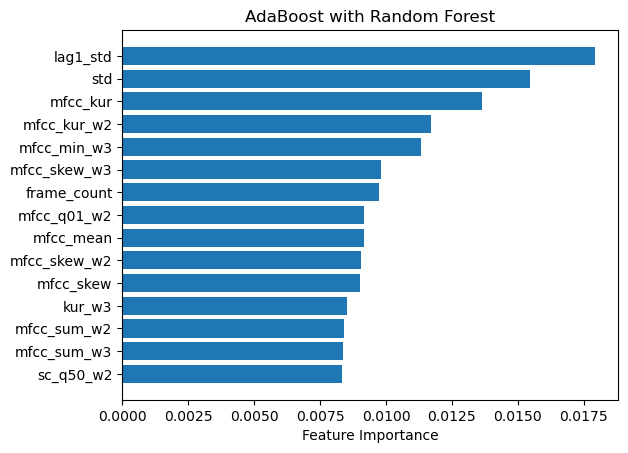

['sc_q50_w2' 'mfcc_sum_w3' 'mfcc_sum_w2' 'kur_w3' 'mfcc_skew'
 'mfcc_skew_w2' 'mfcc_mean' 'mfcc_q01_w2' 'frame_count' 'mfcc_skew_w3'
 'mfcc_min_w3' 'mfcc_kur_w2' 'mfcc_kur' 'std' 'lag1_std']


In [66]:
nbr_features = 15

feature_importances_abc2 = abc2.feature_importances_
sorted_idx2 = feature_importances_abc2.argsort()[-nbr_features:]

y_ticks2 = np.arange(0, len(sorted_idx))
fig, ax = plt.subplots()
plt.barh(y_ticks2, feature_importances_abc2[sorted_idx2])
plt.yticks(y_ticks2, np.array(df_train.columns)[sorted_idx2])
plt.title("AdaBoost with Random Forest")
plt.xlabel('Feature Importance')
plt.show()
print(np.array(df_train.columns)[sorted_idx2])

In [60]:
important_feat_abc1=list(np.array(df_train.columns)[sorted_idx])
important_feat_abc2=list(np.array(df_train.columns)[sorted_idx2])

In [64]:
elementi_comuni = list(set(important_feat_abc2) & set(important_feat_abc1))
elementi_comuni

['sc_q50_w2',
 'mfcc_kur',
 'frame_count',
 'std',
 'lag1_std',
 'mfcc_kur_w2',
 'kur_w3']

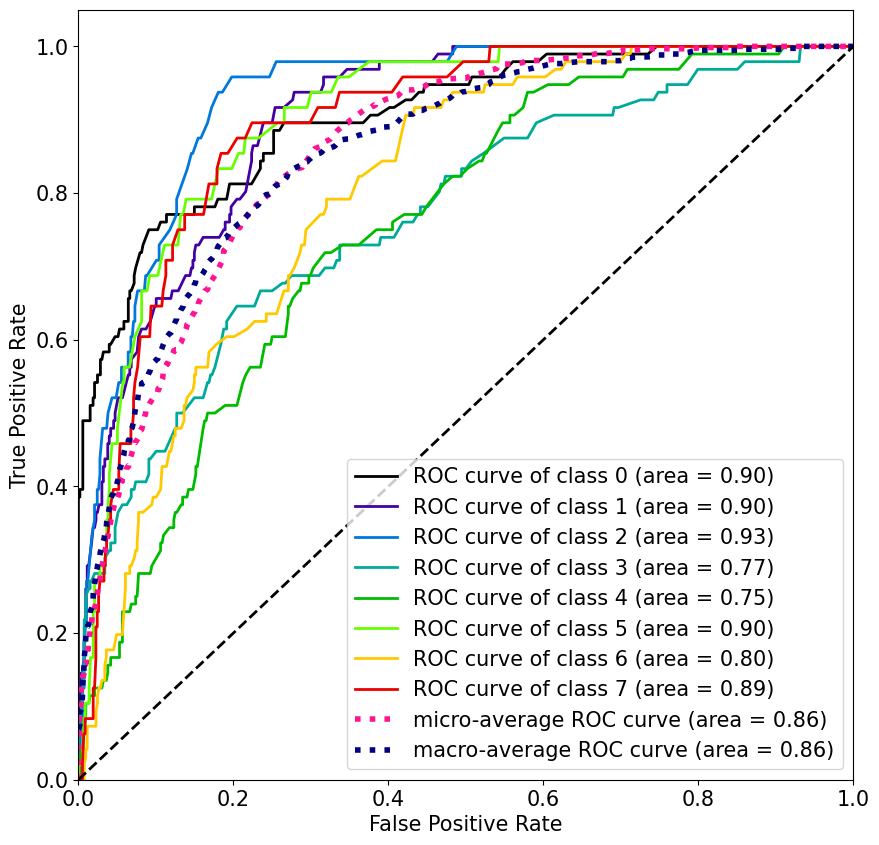

In [68]:
# Del migliore adaboost, che quindi (ovviamente) è quello con Random Forest come modello, vado a plottare anche le ROC e la confusion matrix
y_score_abc= abc2.predict_proba(x_test)
plot_roc(y_test, y_score_abc, figsize=(10,10), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.show()

array([[75,  0,  2,  0,  8,  1,  2,  8],
       [ 0, 61,  3,  1, 13,  2, 16,  0],
       [14,  2, 14,  3,  5,  0,  3,  7],
       [24,  3,  3, 28, 19,  2, 10,  7],
       [19,  5,  0,  8, 43,  2,  7, 12],
       [ 2,  6,  1,  0, 10, 13, 15,  1],
       [ 5, 34,  6,  2, 11,  5, 31,  2],
       [ 6,  0,  1,  9,  5,  2,  3, 22]])

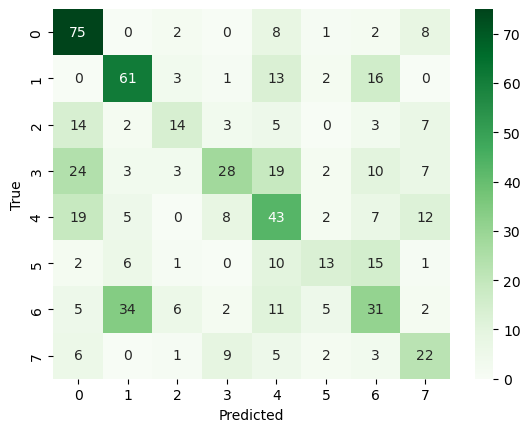

In [70]:
cm_abc = confusion_matrix(y_test, y_pred_abc2)
sns.heatmap(cm_abc, annot=True, cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('True')
cm_abc

<h3>GRADIENT BOOST E VARIAZIONI</h3>

In [67]:
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

Cosa vado a fare: <br>
- Allenare un classificatore base di Gradient Boost, proprio con i valori di default come benchmark (poi se avrò tempo faccio anche parameter tuning)
- Allenare un Light GBM facendo hyperparameter tuning e creare qualche grafico carino

In [72]:
# Alleno un Gradient Boost base di riferimento: 
gbc = GradientBoostingClassifier(random_state=42) #non specifico altri parametri, li tengo tutti di default
gbc.fit(x_train, y_train)

y_pred_gbc = gbc.predict(x_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred_gbc))
print('F1-score %s' % f1_score(y_test, y_pred_gbc, average=None))
print(classification_report(y_test, y_pred_gbc))

#Così senza tuning è 0.4983 - quindi molto buono 

Accuracy 0.4983974358974359
F1-score [0.70742358 0.61       0.60550459 0.40789474 0.37810945 0.3902439
 0.33707865 0.43298969]
              precision    recall  f1-score   support

           0       0.61      0.84      0.71        96
           1       0.59      0.64      0.61        96
           2       0.54      0.69      0.61        48
           3       0.55      0.32      0.41        96
           4       0.36      0.40      0.38        96
           5       0.47      0.33      0.39        48
           6       0.37      0.31      0.34        96
           7       0.43      0.44      0.43        48

    accuracy                           0.50       624
   macro avg       0.49      0.50      0.48       624
weighted avg       0.49      0.50      0.49       624



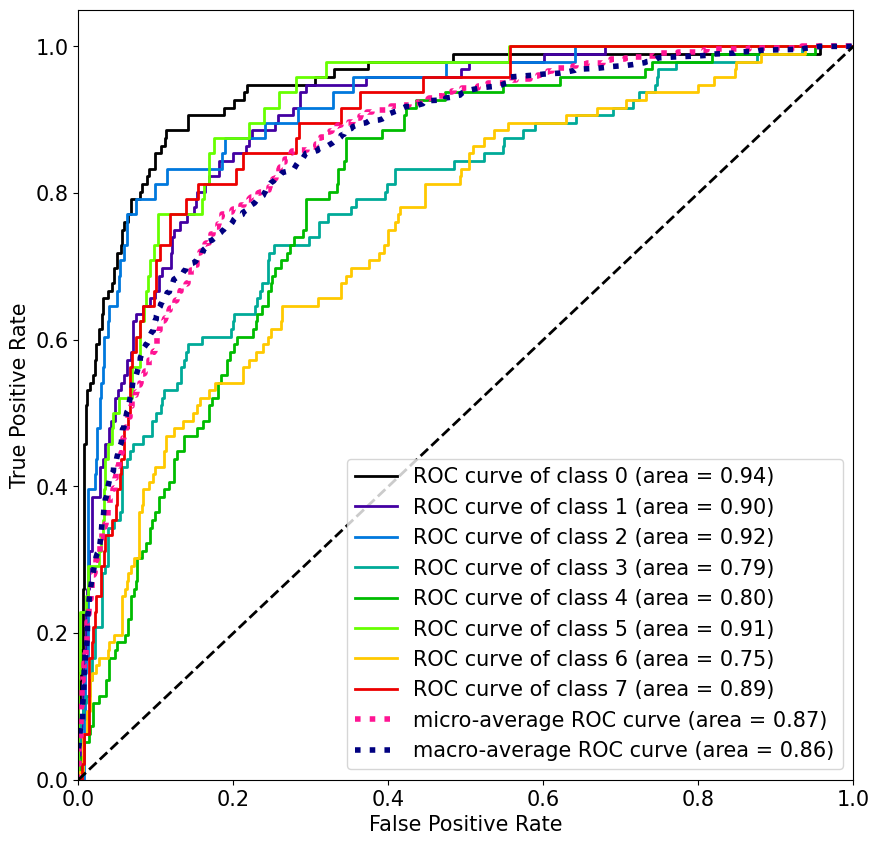

In [73]:
# Plotto la ROC e la confusion matrix, giusto per averle
y_score_gbc= gbc.predict_proba(x_test)
plot_roc(y_test, y_score_gbc, figsize=(10,10), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.show()



array([[81,  0,  2,  1,  3,  2,  0,  7],
       [ 1, 61,  1,  0, 12,  2, 19,  0],
       [ 6,  1, 33,  2,  3,  0,  2,  1],
       [16,  2,  9, 31, 25,  3,  4,  6],
       [20,  1,  2, 11, 38,  2, 11, 11],
       [ 3,  4,  0,  1,  8, 16, 14,  2],
       [ 1, 34, 11,  1, 11,  7, 30,  1],
       [ 5,  1,  3,  9,  5,  2,  2, 21]])

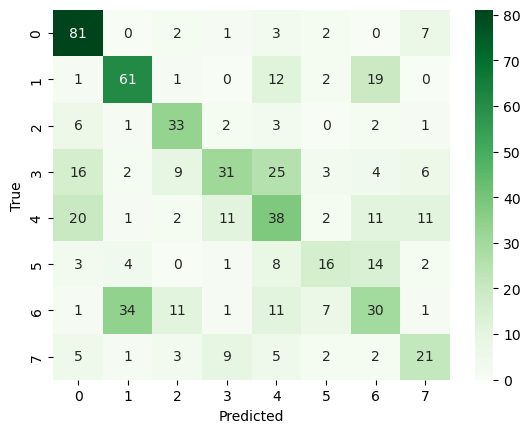

In [74]:
cm_gbc = confusion_matrix(y_test, y_pred_gbc)
sns.heatmap(cm_gbc, annot=True, cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('True')
cm_gbc

In [81]:
#!pip install xgboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 667.8 kB/s eta 0:00:0000:0100:01


In [82]:
# Ho problemi con la libreria che usa Light GBM -> uso XGBoost
from xgboost import XGBClassifier

In [83]:
# Inizializzo il classificatore
xbg=XGBClassifier(random_state=42)

In [85]:
param_list = {'n_estimators': [20, 50, 75, 100, 125, 150, 200],
              'learning_rate': [0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 1],
              #'gamma': [0.0, 0.1, 0.2],
              'reg_lambda': [0.0, 0.5, 1.0], #L2 regularization
              'reg_alpha': [0.0, 0.5, 1.0], #L1 regularization
              #'tree_method':['exact','approx'],
              'booster':['gbtree','gblinear'],
              'max_depth': [3,5,10],
             }

random_search = RandomizedSearchCV(xbg, param_distributions=param_list, n_iter=30, cv=5, random_state=42)
random_search.fit(x_train, y_train)
print(random_search.best_params_)

# Migliori parametri:
# {'reg_lambda': 1.0, 'reg_alpha': 0.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.3, 'booster': 'gbtree'}

/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:41:11] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)
/Users/dilettaferri/opt/anaconda3/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [17:41:12] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:742: 
Parameters: { "max_depth" } are not used.

  warnings.warn(smsg, UserWarning)


{'reg_lambda': 1.0, 'reg_alpha': 0.0, 'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.3, 'booster': 'gbtree'}


In [86]:
# Alleno quello migliore che viene fuori
xgb = XGBClassifier(objective='binary:logistic', 
                    reg_lambda=1.0, #Essendo ad 1 vuol dire che la usiamo - L2 Regularization 
                    reg_alpha=0.0, #Essendo a 0 vuol dire che non la usiamo - L1 Regularization
                    n_estimators=200, 
                    max_depth=3,
                    learning_rate=0.3,
                    booster='gbtree',
                    use_label_encoder=False,
                    random_state=42
                   )


xgb.fit(x_train, y_train)

y_pred_xgb = xgb.predict(x_test)

print('Accuracy %s' % accuracy_score(y_test, y_pred_xgb))
print('F1-score %s' % f1_score(y_test, y_pred_xgb, average=None))
print(classification_report(y_test, y_pred_xgb))

# Otteniamo un'accuracy di 0.5080 - che quindi è leggermente maggiore rispetto a quella trovata dal normale Gradient Boost

Accuracy 0.5080128205128205
F1-score [0.68049793 0.60301508 0.55855856 0.36619718 0.46315789 0.4950495
 0.34883721 0.41304348]
              precision    recall  f1-score   support

           0       0.57      0.85      0.68        96
           1       0.58      0.62      0.60        96
           2       0.49      0.65      0.56        48
           3       0.57      0.27      0.37        96
           4       0.47      0.46      0.46        96
           5       0.47      0.52      0.50        48
           6       0.39      0.31      0.35        96
           7       0.43      0.40      0.41        48

    accuracy                           0.51       624
   macro avg       0.50      0.51      0.49       624
weighted avg       0.50      0.51      0.49       624



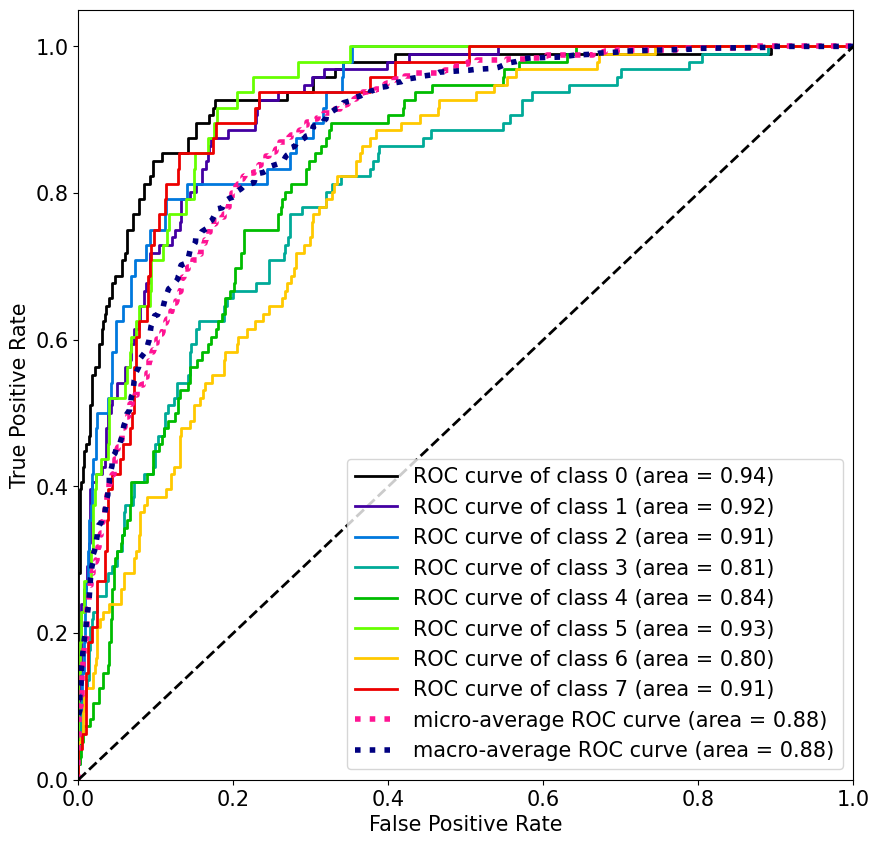

In [87]:
# Plotto la ROC e la confusion matrix, giusto per averle
y_score_xgb= xgb.predict_proba(x_test)
plot_roc(y_test, y_score_xgb, figsize=(10,10), title_fontsize=15, text_fontsize=15)
plt.title("")
plt.show()

array([[82,  0,  2,  0,  4,  1,  0,  7],
       [ 1, 60,  3,  0,  8,  8, 16,  0],
       [10,  0, 31,  0,  4,  0,  2,  1],
       [21,  4, 10, 26, 18,  3,  9,  5],
       [21,  0,  1,  7, 44,  6,  8,  9],
       [ 3,  4,  0,  0,  4, 25, 10,  2],
       [ 2, 33, 14,  1,  7,  8, 30,  1],
       [ 5,  2,  2, 12,  5,  2,  1, 19]])

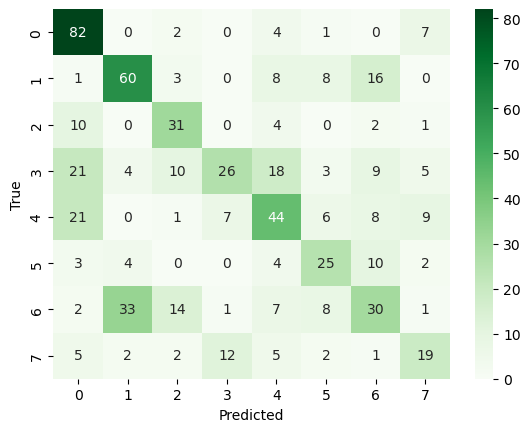

In [88]:
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, cmap="Greens")
plt.xlabel('Predicted')
plt.ylabel('True')
cm_xgb

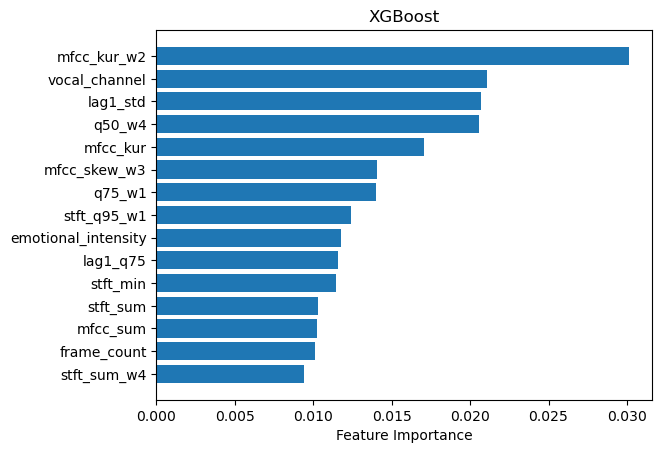

['stft_sum_w4' 'frame_count' 'mfcc_sum' 'stft_sum' 'stft_min' 'lag1_q75'
 'emotional_intensity' 'stft_q95_w1' 'q75_w1' 'mfcc_skew_w3' 'mfcc_kur'
 'q50_w4' 'lag1_std' 'vocal_channel' 'mfcc_kur_w2']


In [89]:
#Prendiamo la feature importance delle prime 15 del modello migliore (XGBoost)
nbr_features = 15

feature_importances_xgb = xgb.feature_importances_
sorted_idx3 = feature_importances_xgb.argsort()[-nbr_features:]

y_ticks3 = np.arange(0, len(sorted_idx3))
fig, ax = plt.subplots()
plt.barh(y_ticks3, feature_importances_xgb[sorted_idx3])
plt.yticks(y_ticks3, np.array(df_train.columns)[sorted_idx3])
plt.title("XGBoost")
plt.xlabel('Feature Importance')
plt.show()
print(np.array(df_train.columns)[sorted_idx3])

In [104]:
for i in sorted_idx3:
    print(i, np.array(df_train.columns)[i],feature_importances_xgb[i] )

224 stft_sum_w4 0.009433661
0 frame_count 0.010082469
17 mfcc_sum 0.0102231465
42 stft_sum 0.010316393
45 stft_min 0.01144547
11 lag1_q75 0.0115914345
233 emotional_intensity 0.011737198
100 stft_q95_w1 0.012426417
56 q75_w1 0.013973802
166 mfcc_skew_w3 0.014088323
26 mfcc_kur 0.017049754
185 q50_w4 0.020574758
9 lag1_std 0.02071072
232 vocal_channel 0.02106011
126 mfcc_kur_w2 0.030119803


In [ ]:
xgb = XGBClassifier(objective='binary:logistic', reg_lambda=1.0, reg_alpha=0.0, n_estimators=k, max_depth=3, learning_rate=0.3, booster='gbtree', use_label_encoder=False,random_state=42)

In [99]:
#Vado anche a plottare l'accuracy del modello rispetto al numero di stimatori
max_k=200
acc_xgb = []
acc_gbc=[]

for k in range(20, max_k+1,5):
    xgb1 = XGBClassifier(objective='binary:logistic', reg_lambda=1.0, reg_alpha=0.0, n_estimators=k, max_depth=3, learning_rate=0.3, booster='gbtree', use_label_encoder=False,random_state=42)
    gbc1 = GradientBoostingClassifier(n_estimators=k)
    xgb1.fit(x_train, y_train)
    gbc1.fit(x_train,y_train)
    
    y_pred_xgb1 = xgb1.predict(x_test)
    y_pred_gbc1 = gbc1.predict(x_test)

    acc_xgb.append(accuracy_score(y_test, y_pred_xgb1))
    acc_gbc.append(accuracy_score(y_test, y_pred_gbc1))
    print(f'{k}th fit done')

20th fit done
25th fit done
30th fit done
35th fit done
40th fit done
45th fit done
50th fit done
55th fit done
60th fit done
65th fit done
70th fit done
75th fit done
80th fit done
85th fit done
90th fit done
95th fit done
100th fit done
105th fit done
110th fit done
115th fit done
120th fit done
125th fit done
130th fit done
135th fit done
140th fit done
145th fit done
150th fit done
155th fit done
160th fit done
165th fit done
170th fit done
175th fit done
180th fit done
185th fit done
190th fit done
195th fit done
200th fit done


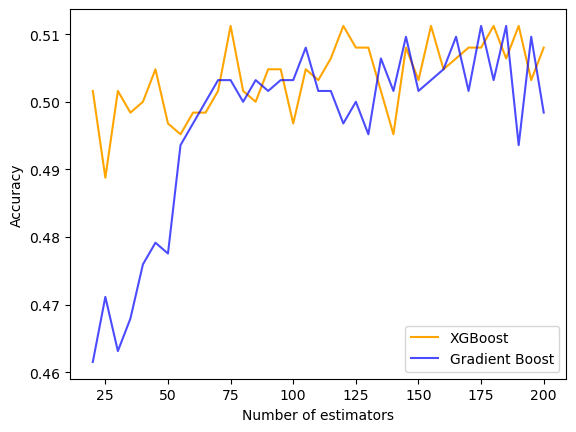

In [102]:
k_values = list(range(20, 201,5))

# Plotting
plt.plot(k_values, acc_xgb, label='XGBoost', color='orange')
plt.plot(k_values, acc_gbc, label='Gradient Boost', color='blue', alpha=0.7)


# Adding labels and title
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')

# Adding a legend
plt.legend()

#plt.ylim(0.48, 0.52)  # Replace 0 and 1 with your desired y-axis range

# Display the plot
plt.show()